# Computation of transmon quasiparticle decay

We simulate T1 decay from quasiparticle tunneling in the charge basis.

### Initialization

In [1]:
import numpy as np
import scipy as sp
from qutip import *
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns 
import time
import pickle
sns.reset_defaults()
%matplotlib inline
sns.set_context('paper', font_scale = 2)
mpl.rcParams['axes.linewidth'] = 0.5
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
mpl.rcParams['mathtext.fontset'] = 'stix'
params = {'legend.fontsize': 8,
          'legend.handlelength': 1,
          'legend.handletextpad': 0.5}
mpl.rcParams.update(params)

### Transmon Hamiltonian in charge basis

In [2]:
### Operators ###

# Identity
def I(n):
    return qeye(2*n+1)

# Charge operator
def Q(n):
    return Qobj( np.diag(np.arange(-n,n+1)) )

# Displacement operator D^+
def Dp(n, k=1):
    if 2*n-k > 0:
        d = np.ones(2*n+1-k)
        return Qobj( np.diag(d, k=-k) )
    else:
        return Qobj( np.zeros((2*n, 2*n)) )

# Displacement operator D^-
def Dm(n, k=1):
    return Dp(n, k).trans()

In [3]:
def eigs_transmon(Ej, Cap, f=0.5, q=0.0, return_hamiltonian=False):
    """
    Ej : float | Energy of large junction in GHz
    Cap: float | Capacitance in fF
    f  : float | External flux in range [0,1]
    q  : float | External charge offset in e
    """

    # Initialization
    n1 = 100 #charge state truncation number

    # Fundamental constants
    e    = 1.60217662 * 10**(-19) #elementary charge
    h    = 6.62607004 * 10**(-34) #Planck constant
    Phi0 = 2.06783385 * 10**(-15) #flux quantum
    
    # Capacitative energy (in GHz)
    Cap  = Cap * 1e-15

    # Define operators
    I1 = I(n1)
    N1 = Q(n1)
    Dp1 = Dp(n1)
    Dm1 = Dm(n1)

    # Capacitive (kinetic) part of Hamiltonian
    T = 0
    Cinv = 1/Cap
    T += Cinv * tensor((N1+q*I1)**2)
    T *= 2*e**2/h/1e9

    # Inductive (potential) part of Hamiltonian
    U = 0
    D = Dp1+Dm1
    U += -Ej * np.abs(np.cos(2*np.pi*f)) * tensor(D) #deleted erroneous factor 2**(1-(i==j))

    # Assemble Hamiltonian
    H = T + U
    
    # Return Hamiltonian matrix if desired by user
    if return_hamiltonian:
        return H
    
    # Compute eigenstates and eigenvalues
    evals, estates = H.tidyup().eigenstates(eigvals=10, sparse=True)
    #values, vectors = sp.sparse.linalg.eigsh(H.data, k=6, v0=None, which='SA', maxiter=1e7)
    #order = np.argsort(values)
    #evals = values[order]
    #estates = vectors[order]
    
    return evals, estates

In [4]:
def spec_transmon(Ej, Cap, f_sweep=np.linspace(0,1,11), q=0.0, normalized=True):
    """
    Ej : float | Energy of large junction in GHz
    Cap: float | Capacitance in fF
    f  : float | External flux in range [0,1]
    q  : float | External charge offset in e
    """

    # Initialization
    spec = []

    # Calculate spectrum for swept parameter
    for f in f_sweep:
        spec.append( eigs_transmon(Ej, Cap, f, q)[0] )
        print(np.round(f,2), end=' ')
    spec = np.array(spec)

    # Normalize spectrum by ground state if desired
    if normalized:
        e0 = np.array([spec[i][0] for i in range(len(spec))])
        spec = (spec.T - e0).T

    print('Sweep done!')
        
    return spec

In [5]:
# Flux sweep simulation, sweeping first qubit - with coupling
Ej = 22
n=2
Csum = 91
f_sweep = np.linspace(0,1,101)
spec = spec_transmon(Ej, Csum, f_sweep)

0.0 0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1 0.11 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2 0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28 0.29 0.3 0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4 0.41 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5 0.51 0.52 0.53 0.54 0.55 0.56 0.57 0.58 0.59 0.6 0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7 0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8 0.81 0.82 0.83 0.84 0.85 0.86 0.87 0.88 0.89 0.9 0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99 1.0 Sweep done!


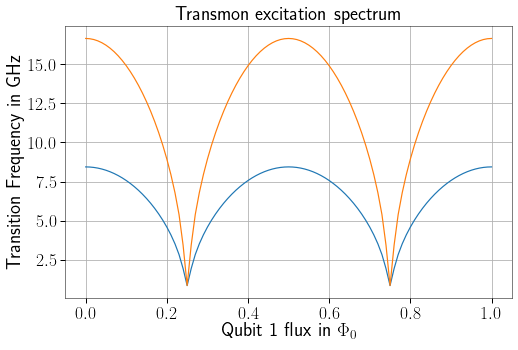

In [6]:
plt.figure(figsize=(8,5))
plt.plot(f_sweep, spec[:,1:3])
plt.title("Transmon excitation spectrum")
plt.xlabel(r'Qubit 1 flux in $\Phi_0$')
plt.ylabel('Transition Frequency in GHz')
plt.grid(True)
plt.show()

### Compute quasiparticle decay in charge basis

We use the procedure from the Supplementary Information of [Yan2016](https://www.nature.com/articles/ncomms12964). The T1 decay is computed at the sweetspot $\Phi_\text{ext} = 0\,\Phi_0$.

In [7]:
# States without quasiparticle on the node
E0 = eigs_transmon(Ej, Csum, f=0.0, q=0.0)[0][0]
E1 = eigs_transmon(Ej, Csum, f=0.0, q=0.0)[0][1]
f01 = E1 - E0
print('Qubit frequency: {} GHz'.format(f01))
g_even = eigs_transmon(Ej, Csum, f=0.0, q=0.0)[1][0].full()
e_even = eigs_transmon(Ej, Csum, f=0.0, q=0.0)[1][1].full()

Qubit frequency: 8.437549583426932 GHz


In [8]:
# States WITH quasiparticle on the node
g_odd = eigs_transmon(Ej, Csum, f=0.0, q=0.5)[1][0].full()
e_odd = eigs_transmon(Ej, Csum, f=0.0, q=0.5)[1][1].full()

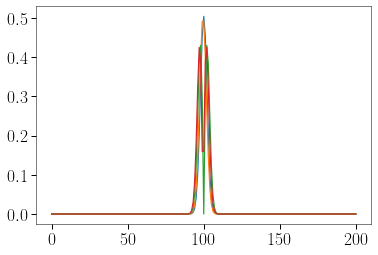

In [9]:
# Plot eigenstates with and without quasiparticle
plt.figure()
plt.plot(np.abs(g_even))
plt.plot(np.abs(g_odd))
plt.plot(np.abs(e_even))
plt.plot(np.abs(e_odd))
plt.show()

In [10]:
# Quasiparticle tunneling matrix element
m_qp = np.abs(np.dot(g_even.T,e_odd)[0][0])**2
print('Matrix element:', m_qp)

Matrix element: 0.0245886049321641


In [11]:
# Braket of odd and even excited state:
print(np.abs(np.dot(e_even.T,e_odd)[0][0]))
# Braket of even ground state and excited state
print(np.abs(np.dot(g_even.T,e_even)[0][0]))

0.9618831729874471
1.83111450612732e-14


In [12]:
# Compute quasiparticle T1 time (SI Eq. (31) of [Yan2016])
x_qp     = 1e-7 #from https://www.nature.com/articles/ncomms6836: x_xp is between 1e-6 and 1e-7
delta_al = 80 #in GHz
S_qp     = x_qp*Ej*np.sqrt(8*delta_al/f01)
print('S_qp:', S_qp, 'GHz')

T1_qp = 1/(0.25*m_qp*S_qp)/1e9 #in seconds
print('T1:', T1_qp*1e3, 'ms')

S_qp: 1.9160396800630547e-05 GHz
T1: 8.490271991046534 ms


<strike>The estimated T1 decay is just about $3\,\text{ns}$ and thus much shorter than expected. We think that the problem lies with the noise spectral density S_qp: There is probably an error in the formula. We will check [Catelani2011](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.106.077002) to find the right expression.</strike>

SOLVED IT! x_qp is greatly underestimated by the formula we used previously (see cell below). The [Wang2014](https://www.nature.com/articles/ncomms6836) paper gives good values such that we are now in the T1_qp ~ ms regime for the transmon, as expected.

In [13]:
# # Using the Catelani paper, eqs. 6, 9, 11
# kB = 1.38064852e-23
# h  = 6.62607004 * 10**(-34)
# e  = 1.60217662 * 10**(-19)
# #calculate x_qp
# # x_qp = np.sqrt(2*np.pi * kB*10e-3/(h*90e9)) * np.exp(-h*90e9/(kB*10e-3)) #<< grossly underestimates x_qp
# x_qp = 1e-7 #from https://www.nature.com/articles/ncomms6836
# print(x_qp)
# #... to figure out Re(Y_qp) and then the noise spectral density, one needs to calculate the junction conductance